In [2]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout, Input, Embedding, Bidirectional, Lambda
from keras import Model
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import spacy
import en_core_web_sm

In [3]:
# preparin question/class datast to train Siamese Net

original_questions_dataset = pd.DataFrame(columns=['question', 'class'])
question_paths = [r'questions\1_3g4G modem.txt',
                  r'questions\2_Change of Ownership.txt',
                  r'questions\3_Economical Packages.txt',
                  r'questions\4_FTTH Service.txt',
                  r'questions\5_Participate in auction.txt',
                  r'questions\6_Postpaid SIM.txt',
                  r'questions\7_Prepaid SIM.txt',
                  r'questions\8_TD-LTE modem.txt']

for index, path in enumerate(question_paths):
    tmp_dataset = pd.read_csv(path, sep='\n\n', header=None, engine='python')
    tmp_dataset.columns = ['question']
    tmp_dataset['class'] = index+1
    original_questions_dataset = pd.concat(
        [original_questions_dataset, tmp_dataset], ignore_index=True)

original_questions_dataset

,question,class
0,What is the customer obligated to do before pu...,1
1,What happens if the customer enters inaccurate...,1
2,What is the customer's responsibility at the t...,1
3,What should the customer avoid doing when rece...,1
4,What does the customer need to provide at the ...,1
...,...,...
1011,"What is required for regular delivery, and how...",8
1012,What valid identity documents are acceptable f...,8
1013,What valid identity document is acceptable for...,8
1014,What actions can the Subscriber take if the po...,8


## Doing Pre-Processing On Questions


In [4]:
nlp = en_core_web_sm.load()
questions_dataset = pd.DataFrame(columns=['question', 'class'])


def preProcessing(doc):
    text_without_stop_words = [t.text for t in nlp(doc) if not t.is_stop]
    text_without_stop_words = " ".join(text_without_stop_words)
    lemmas = [t.lemma_ for t in nlp(text_without_stop_words)]
    return " ".join(lemmas)


questions_dataset['question'] = original_questions_dataset['question'].map(
    preProcessing)
questions_dataset['class'] = original_questions_dataset['class']
questions_dataset.head()

,question,class
0,customer obligate purchase mobile modem ?,1
1,happen customer enter inaccurate identity info...,1
2,customer responsibility time deliver package ?,1
3,customer avoid receive package postman ?,1
4,customer need provide time place order ?,1


In [5]:
texts_dataset = pd.DataFrame(columns=['text', 'class'])
text_paths = [r'data\1_3g4G modem.txt',
              r'data\2_Change of Ownership.txt',
              r'data\3_Economical Packages.txt',
              r'data\4_FTTH Service.txt',
              r'data\5_Participate in auction.txt',
              r'data\6_Postpaid SIM.txt',
              r'data\7_Prepaid SIM.txt',
              r'data\8_TD-LTE modem.txt']

for index, path in enumerate(text_paths):
    texts = pd.read_csv(path, sep='\n\n', header=None,
                        engine='python')[0].str.cat(sep=" ")
    tmp_dataset = pd.DataFrame([texts], columns=['text'])
    tmp_dataset.columns = ['text']
    tmp_dataset['class'] = index+1
    texts_dataset = pd.concat([texts_dataset, tmp_dataset], ignore_index=True)

texts_dataset

,text,class
0,Customer Obligations: Before purchasing any mo...,1
1,"Before changing SIM card ownership, the seller...",2
2,Economical Package: the subscriber can use unl...,3
3,"Customer Obligations: Before purchasing, the C...",4
4,The subscribers shall accept the following ter...,5
5,"To use Irancell online store services, the App...",6
6,"To use Irancell online store services, the App...",7
7,Customer Obligations: Before purchasing any TD...,8


In [6]:
# preparing word tokenizer
tokens = " ".join(questions_dataset['question']).split()

MAX_LEN = 40
vocab_size = 1000
embed_size = 100  # ==> 50
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(tokens)

## Using Pre-Trained Word Embedding


In [6]:
# path_to_glove_file = "glove\glove.6B.100d.txt"
path_to_glove_file = 'glove\glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
glove_word_index = {word: index for index,
                    word in enumerate(embeddings_index.keys())}
len(glove_word_index)

400000

In [14]:
# word_index = tokenizer.word_index
word_index = glove_word_index
num_tokens = len(word_index) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 400000 words (0 misses)


## LSTM model for first part of Siamese Network


In [15]:
MAX_LEN = 40

first_sent_in = Input(shape=(MAX_LEN, ))
second_sent_in = Input(shape=(MAX_LEN, ))

embedding_layer = Embedding(input_dim=num_tokens,
                            output_dim=embedding_dim,
                            input_length=MAX_LEN,
                            trainable=True,
                            mask_zero=True)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

first_sent_embedding = embedding_layer(first_sent_in)
second_sent_embedding = embedding_layer(second_sent_in)

lstm = Bidirectional(LSTM(units=256,
                          return_sequences=False))

first_sent_encoded = lstm(first_sent_embedding)
second_sent_encoded = lstm(second_sent_embedding)
def l1_norm(x): return 1 - K.abs(x[0] - x[1])


merged = Lambda(function=l1_norm,
                output_shape=lambda x: x[0],
                name='L1_distance')([first_sent_encoded, second_sent_encoded])

predictions = Dense(1, activation='sigmoid',
                    name='classification_layer')(merged)

model = Model([first_sent_in, second_sent_in], predictions)

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])

path = r'models/lstm_siameseNet/'
model.load_weights(path)
# model.save_weights(path)

In [121]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 50)       20000100    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 512)          628736      ['embedding[0][0]',          

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    questions_dataset['question'].values, questions_dataset['class'].values, test_size=0.2, shuffle=True)

x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, padding=pad_type,
                        truncating=trunc_type, maxlen=MAX_LEN)

x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, padding=pad_type,
                       truncating=trunc_type, maxlen=MAX_LEN)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

### Training LSTM


In [24]:
train_length = len(x_train)

for i in tqdm(range(1000)):

    batch_size = 512
    indexes1 = np.random.randint(0, train_length, batch_size)
    questions1 = np.array([x_train[index] for index in indexes1])

    indexes2 = np.random.randint(0, train_length, batch_size)
    questions2 = np.array([x_train[index] for index in indexes2])

    labels = np.array([1 if y_train[index1] == y_train[index2]
                      else 0 for index1, index2 in zip(indexes1, indexes2)])

    model.fit(x=[questions1, questions2], y=labels, epochs=1, verbose=0)

model.save_weights(path)

100%|██████████| 1000/1000 [06:09<00:00,  2.71it/s]


In [25]:
# validating
fsents = questions_dataset[questions_dataset['class'] == 7]['question']

fsents = tokenizer.texts_to_sequences(fsents)

fsents = pad_sequences(fsents, padding=pad_type,
                       truncating=trunc_type, maxlen=MAX_LEN)

ssents = questions_dataset[questions_dataset['class'] == 6]['question']

ssents = tokenizer.texts_to_sequences(ssents)

ssents = pad_sequences(ssents, padding=pad_type,
                       truncating=trunc_type, maxlen=MAX_LEN)

predictions = model.predict([fsents[:30], ssents[:30]])

print(np.round(predictions).reshape(1, -1))

1/1 [==============================] - 3s 3s/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [60]:
path = r'models/lstm_siameseNet/'
model.load_weights(path)

dense1 = Dense(32, activation='tanh', name='dense1')
dense2 = Dense(32, activation='tanh', name='dense2')
classifier = Dense(9, activation='softmax', name='classifier_layer')

# input must be tokenized
siamese_net = tf.keras.models.Sequential()
siamese_net.add(Input(shape=(MAX_LEN, )))

embedding_layer = model.layers[2]
embedding_layer.trainable = False
siamese_net.add(embedding_layer)

lstm = model.layers[3]  # bidirectional lstm
lstm.trainable = False
siamese_net.add(lstm)

siamese_net.add(dense1)
siamese_net.add(Dropout(0.2))
siamese_net.add(dense2)
siamese_net.add(Dropout(0.2))
siamese_net.add(classifier)

siamese_net.compile(loss='categorical_crossentropy',
                    optimizer="RMSprop",
                    metrics=["accuracy"])


callback = tf.keras.callbacks.ModelCheckpoint(filepath=r'models/siamese_net/',
                                              save_best_only=True,
                                              save_weights_only=True,
                                              monitor='val_accuracy',
                                              mode='max')

# siamese_net.load_weights(r'models\siamese_net')

In [61]:
history = siamese_net.fit(x_train,
                          y_train_encoded,
                          batch_size=128,
                          epochs=20,
                          verbose=1,
                          validation_data=(x_test, y_test_encoded),
                          callbacks=[callback])

Epoch 1/20
7/7 [==============================] - 7s 381ms/step - loss: 1.6635 - accuracy: 0.4988 - val_loss: 1.1686 - val_accuracy: 0.7304
Epoch 2/20
7/7 [==============================] - 1s 82ms/step - loss: 0.9076 - accuracy: 0.8399 - val_loss: 0.9234 - val_accuracy: 0.7696
Epoch 3/20
7/7 [==============================] - 0s 67ms/step - loss: 0.6693 - accuracy: 0.8941 - val_loss: 0.7996 - val_accuracy: 0.7745
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5305 - accuracy: 0.9064 - val_loss: 0.7639 - val_accuracy: 0.7696
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 0.4579 - accuracy: 0.9027 - val_loss: 0.7363 - val_accuracy: 0.7647
Epoch 6/20
7/7 [==============================] - 0s 61ms/step - loss: 0.3910 - accuracy: 0.9126 - val_loss: 0.7029 - val_accuracy: 0.7843
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3537 - accuracy: 0.9224 - val_loss: 0.7039 - val_accuracy: 0.7745
Epoch 8/20
7/7 [==========

In [63]:
# siamese_net.load_weights(r'models\siamese_net')
# siamese_net.save('models/siamese_complete_model/model.h5')
siamese_net.evaluate(x_test, y_test_encoded)

7/7 [==============================] - 0s 11ms/step - loss: 0.9465 - accuracy: 0.7990


[0.9465023279190063, 0.7990196347236633]

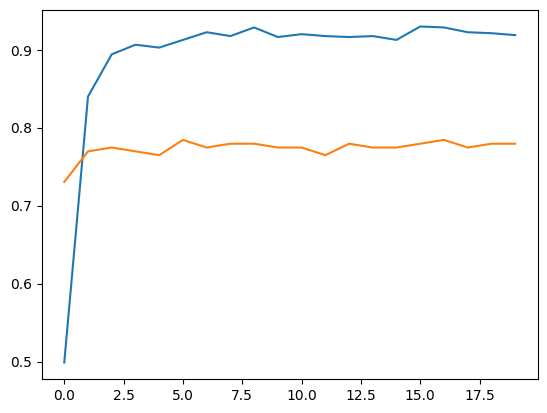

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

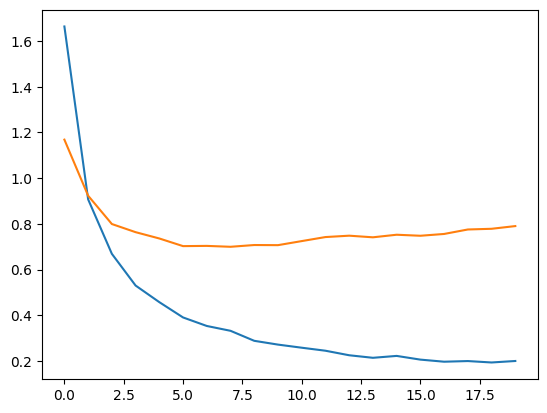

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Inference


In [7]:
from transformers import TFAutoModelForQuestionAnswering
from transformers import AutoTokenizer
from transformers import pipeline
from keras.models import load_model

model_checkpoint = "bert-base-cased"
qa_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model_checkpoint = 'models/QA_model/'
qa_model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

model_checkpoint = 'models/QA_model/'
QA_pipeline = pipeline("question-answering",
                       model=model_checkpoint, tokenizer=qa_tokenizer)

siamese_net = load_model('models/siamese_complete_model/model.h5')
qa_model.summary()

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at models/QA_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.
All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at models/QA_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


Model: "tf_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 107,721,218
Trainable params: 107,721,218
Non-trainable params: 0
_________________________________________________________________


In [14]:
classes = ['1_3g4G modem',
           '2_Change of Ownership',
           '3_Economical Packages',
           '4_FTTH Service',
           '5_Participate in auction',
           '6_Postpaid SIM',
           '7_Prepaid SIM',
           '8_TD-LTE modem']

dataset_slice = original_questions_dataset.sample(10)
sample_indexes = dataset_slice.index
# sample_contexts = texts_dataset.iloc[sample_indexes]['text'.values]
sample_questions = original_questions_dataset.iloc[sample_indexes]['question'].values
sample_classes = original_questions_dataset.iloc[sample_indexes]['class'].values

for index, question in enumerate(sample_questions):

    original_question = question
    preprocessed_question = preProcessing(original_question)

    question_tokenized = tokenizer.texts_to_sequences([preprocessed_question])
    question_padded = pad_sequences(question_tokenized, padding=pad_type,
                                    truncating=trunc_type, maxlen=MAX_LEN)

    question_class_probs = siamese_net(question_padded)
    question_class = np.argmax(question_class_probs)
    context = texts_dataset['text'][texts_dataset['class']
                                    == question_class].values[0]

    answer = QA_pipeline(question=original_question, context=context)
    print(
        f'Original Class: |{classes[sample_classes[index]-1]}| & Predicted Class: |{classes[question_class-1]}|')
    print(f"Question: {sample_questions[index]}\nAnswer: {answer['answer']}\n")

Original Class: |1_3g4G modem| & Predicted Class: |1_3g4G modem|
Question: What does the Customer need to check before purchasing a mobile modem according to the text?
Answer: Irancell network coverage

Original Class: |5_Participate in auction| & Predicted Class: |5_Participate in auction|
Question: What options are available to a Bidder if they win several bids simultaneously, exceeding the SIM card ownership limit?
Answer: he can pay the full price of each SIM card

Original Class: |7_Prepaid SIM| & Predicted Class: |7_Prepaid SIM|
Question: What information is included in the hard copy of the registration form provided during delivery?
Answer: particulars of the SIM Card owner

Original Class: |8_TD-LTE modem| & Predicted Class: |8_TD-LTE modem|
Question: Why is the return of dual-purpose modems (TD&FD Support) not possible?
Answer: provision of any mobile or fixed internet services

Original Class: |7_Prepaid SIM| & Predicted Class: |7_Prepaid SIM|
Question: What are the requireme